Top frequencies:  [ 558.57758498 1841.31967237 1618.02562859  781.87162876 1841.66214789
  558.23510945  887.86780445 1512.0294529  1841.1484346   558.74882274] Hz
Possible twin-tone pair: 558.5775849767402 Hz, 887.867804446474 Hz
Possible twin-tone pair: 558.2351094494707 Hz, 887.867804446474 Hz
First note is C#5 with frequency 544.2858935545852 Hz
Second note is G#5 with frequency 815.5074061569832 Hz


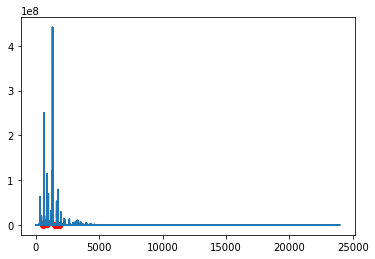

In [44]:
import numpy as np
from scipy.io.wavfile import read
from scipy.fftpack import fft
import matplotlib.pyplot as plt

def frequencies_to_fifth(frequency1, frequency2):
    A4_frequency = 440
    A4_note_number = 69
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

    if frequency2 < frequency1:
        # Swap the frequencies if they're out of order
        frequency1, frequency2 = frequency2, frequency1

    # Calculate note numbers
    note_number1 = np.round(12 * np.log2(frequency1 / A4_frequency) + A4_note_number).astype(int)
    note_number2 = note_number1 + 7  # A perfect fifth is 7 semitones above

    # Get note names and octave numbers
    note_name1 = note_names[note_number1 % 12]
    octave1 = note_number1 // 12 - 1  # MIDI notes are in "Scientific pitch notation", so A0 is note number 21

    note_name2 = note_names[note_number2 % 12]
    octave2 = note_number2 // 12 - 1

    return (note_name1 + str(octave1), 2**((note_number1 - A4_note_number) / 12) * A4_frequency), \
           (note_name2 + str(octave2), 2**((note_number2 - A4_note_number) / 12) * A4_frequency)


# Read the file (assumes you have converted mp3 to wav)
sampling_rate, data = read('./wav-files/AFL Siren Sound Effect.wav')

# If the audio file is stereo (two channels), we need to convert it to mono
if len(data.shape) > 1 and data.shape[1] > 1:
    data = np.mean(data, axis=1)

# Take the FFT
fft_out = fft(data)

# Generate the frequencies associated with the FFT output
frequencies = np.abs(np.fft.fftfreq(len(fft_out), 1.0/sampling_rate))


# Only consider frequencies in the "lower" range of human hearing
mask = (frequencies < 1300) & (frequencies > 100)

# Find the top N frequencies within this mask
N = 10
indices = (-np.abs(fft_out[mask])).argsort()[:N]
top_frequencies = frequencies[indices]

# Print the top frequencies
print('Top frequencies: ', top_frequencies, 'Hz')

twin_tones = []
# Identify pairs of frequencies with a ratio close to 3:2
for i in range(len(top_frequencies)):
    for j in range(i + 1, len(top_frequencies)):
        ratio = top_frequencies[j] / top_frequencies[i]
        if 1.4 < ratio < 1.6:  # Look for ratios close to 3:2
            print(f"Possible twin-tone pair: {top_frequencies[i]} Hz, {top_frequencies[j]} Hz")
            (note1, frequency1), (note2, frequency2) = frequencies_to_fifth(top_frequencies[i], top_frequencies[j])
            twin_tones.append((top_frequencies[i], top_frequencies[j]))

print(f"First note is {note1} with frequency {frequency1} Hz")
print(f"Second note is {note2} with frequency {frequency2} Hz")

# Plot the absolute value of the FFT output versus frequency
plt.plot(frequencies, np.abs(fft_out))
plt.scatter(top_frequencies, np.abs(fft_out)[indices], color='r')  # Mark top frequencies
plt.show()



In [45]:
import numpy as np
from scipy.io.wavfile import write

# Settings
sample_rate = 44100  # Sample rate in Hz
duration = 5.0  # seconds

# Generate the time values for each sample
t = np.arange(int(sample_rate * duration)) / sample_rate

# Generate the audio signal by summing sine waves for each top frequency
signal = np.zeros(len(t))
for frequency in top_frequencies:
    signal += 0.05 * np.sin(2 * np.pi * frequency * t)

# Write to .wav file
scaled_signal = np.int16(signal/np.max(np.abs(signal)) * 32767)
write('./wav-files/combined_sine_waves.wav', sample_rate, scaled_signal)

# Generate only the twin_tones
signal = np.zeros(len(t))
for frequency_pair in twin_tones:
    for frequency in frequency_pair:
        signal += 0.05 * np.sin(2 * np.pi * frequency * t)

# Write to .wav file within range for a 16-bit .wav file
scaled_signal = np.int16(signal/np.max(np.abs(signal)) * 32767)
write('./wav-files/twin_tones.wav', sample_rate, scaled_signal)

# Generate based on note1 and note2
signal = 0.05 * np.sin(2 * np.pi * frequency1 * t)
signal += 0.05 * np.sin(2 * np.pi * frequency2 * t)

# Write to .wav file within range for a 16-bit .wav file
scaled_signal = np.int16(signal/np.max(np.abs(signal)) * 32767)
write('./wav-files/twin_notes.wav', sample_rate, scaled_signal)

# Generate an echo effect the siren
diameter = 152 # Diameter of a cricket field
speed_of_sound = 343 # Speed of sound in m/s
delay = diameter / speed_of_sound  # Delay in seconds
attenuation = 0.6  # Volume reduction factor
echo = np.pad(signal, (int(delay * sample_rate), 0), 'constant') * attenuation

# Add the echo to the original signal
echoed_signal = signal + echo[:len(signal)]

# Ensure the data is within the correct range for a 16-bit .wav file
scaled_signal = np.int16(echoed_signal/np.max(np.abs(echoed_signal)) * 32767)

# Then write to the .wav file
write('./wav-files/echoed_sine_waves.wav', sample_rate, scaled_signal)
